In [61]:
import pandas as pd
import seaborn as sns

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, roc_curve

In [63]:
from imblearn.over_sampling import RandomOverSampler

In [64]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338487 entries, 0 to 338486
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                338487 non-null  int64  
 1   user_address                      338487 non-null  object 
 2   user_balance_usd                  338487 non-null  float64
 3   user_balance_coin_a               338487 non-null  float64
 4   user_historical_transactions_10s  338487 non-null  int64  
 5   user_historical_transactions_30s  338487 non-null  int64  
 6   exchange_a_price                  309845 non-null  float64
 7   exchange_b_price                  338487 non-null  float64
 8   exchange_a_volatility             323277 non-null  object 
 9   exchange_b_volatility             330565 non-null  float64
 10  anonymous                         338487 non-null  object 
 11  result                            338487 non-null  i

In [66]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112830 entries, 0 to 112829
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                112830 non-null  int64  
 1   user_address                      112830 non-null  object 
 2   user_balance_usd                  112830 non-null  float64
 3   user_balance_coin_a               112830 non-null  float64
 4   user_historical_transactions_10s  112830 non-null  int64  
 5   user_historical_transactions_30s  112830 non-null  int64  
 6   exchange_a_price                  103453 non-null  float64
 7   exchange_b_price                  112830 non-null  float64
 8   exchange_a_volatility             107728 non-null  object 
 9   exchange_b_volatility             110036 non-null  float64
 10  anonymous                         112830 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 9.5

In [67]:
train_data.columns

Index(['id', 'user_address', 'user_balance_usd', 'user_balance_coin_a',
       'user_historical_transactions_10s', 'user_historical_transactions_30s',
       'exchange_a_price', 'exchange_b_price', 'exchange_a_volatility',
       'exchange_b_volatility', 'anonymous', 'result'],
      dtype='object')

In [68]:
average_price_diff = (train_data["exchange_a_price"] - train_data["exchange_b_price"]).mean()

In [69]:
def dummies_df_anon (df:pd.DataFrame) -> pd.DataFrame:
    anon_series = df["anonymous"].apply(lambda val: val[0])
    dummies_anon = pd.get_dummies(anon_series, prefix="anon_code")
    df[dummies_anon.columns] = dummies_anon
    return df


In [70]:
def transform_missing_ex_a(df: pd.DataFrame, average_diff:float) -> pd.DataFrame:
    fill_test_na = df["exchange_b_price"] + average_diff
    df["exchange_a_price"] = df["exchange_a_price"].fillna(fill_test_na, inplace=False)
    return df

In [71]:
def transf_adresses (df: pd.DataFrame) -> pd.DataFrame:
    df.user_address = df.user_address.str.lower()
    return df

In [72]:
def dummies_df_wallet (df:pd.DataFrame) -> pd.DataFrame:
    wallet_series = df["user_address"]
    dummies_wallet = pd.get_dummies(wallet_series, prefix="wallet_code")
    df[dummies_wallet.columns] = dummies_wallet
    return df

In [73]:
def get_ids (df: pd.DataFrame) -> pd.Series:
    return df["id"].reset_index(drop=True)

In [77]:
def drop_columns_data (df: pd.DataFrame) -> pd.Series:
    drop_columns = ['id', 'user_address', 'exchange_a_volatility','exchange_b_volatility','anonymous']
    return df.drop(drop_columns, axis=1)

In [78]:
clean_train_data = dummies_df_anon (train_data) 
clean_train_data = transform_missing_ex_a(clean_train_data, average_price_diff)
clean_train_data = transf_adresses (clean_train_data) 
clean_train_data = dummies_df_wallet (clean_train_data) 
clean_train_data

,id,user_address,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,exchange_a_volatility,exchange_b_volatility,anonymous,result,anon_code_A,anon_code_F,anon_code_M,wallet_code_0x56ab,wallet_code_0x5779,wallet_code_0x5aee,wallet_code_0x930b,wallet_code_0xd47a
0,8,0x930b,84139.092267,44.193560,0,0,66.742521,66.8325,very high,0.000367,A113,0,1,0,0,0,0,0,1,0
1,12,0x5779,34609.449276,331.501171,0,0,41.429574,41.5401,low,0.000695,M958,0,0,0,1,0,1,0,0,0
2,28,0x5779,30598.783296,1581.902691,0,0,35.817631,35.8701,very low,0.000431,F255,0,0,1,0,0,1,0,0,0
3,50,0x5779,20992.680359,1260.406181,0,0,47.711827,47.8233,low,0.000456,F2332,0,0,1,0,0,1,0,0,0
4,56,0xd47a,120838.946555,180.090128,0,0,52.812842,52.6869,low,NaN,A198,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338482,3988947,0x5779,29374.263175,352.561329,0,0,46.680615,46.6683,medium,0.000435,M142,0,0,0,1,0,1,0,0,0
338483,3988948,0x5aee,50847.577759,239.577796,0,0,72.139667,360.4125,low,0.000452,A131,0,1,0,0,0,0,1,0,0
338484,3988961,0x930b,121303.381921,160.222687,0,0,52.285416,52.3887,low,0.000285,A2158,0,1,0,0,0,0,0,1,0
338485,3988964,0x5779,18515.028195,1927.485662,0,0,38.559282,38.6211,very low,0.000185,F1831,0,0,1,0,0,1,0,0,0


In [79]:
clean_train_data = drop_columns_data (clean_train_data) 
clean_train_data

,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,result,anon_code_A,anon_code_F,anon_code_M,wallet_code_0x56ab,wallet_code_0x5779,wallet_code_0x5aee,wallet_code_0x930b,wallet_code_0xd47a
0,84139.092267,44.193560,0,0,66.742521,66.8325,0,1,0,0,0,0,0,1,0
1,34609.449276,331.501171,0,0,41.429574,41.5401,0,0,0,1,0,1,0,0,0
2,30598.783296,1581.902691,0,0,35.817631,35.8701,0,0,1,0,0,1,0,0,0
3,20992.680359,1260.406181,0,0,47.711827,47.8233,0,0,1,0,0,1,0,0,0
4,120838.946555,180.090128,0,0,52.812842,52.6869,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338482,29374.263175,352.561329,0,0,46.680615,46.6683,0,0,0,1,0,1,0,0,0
338483,50847.577759,239.577796,0,0,72.139667,360.4125,0,1,0,0,0,0,1,0,0
338484,121303.381921,160.222687,0,0,52.285416,52.3887,0,1,0,0,0,0,0,1,0
338485,18515.028195,1927.485662,0,0,38.559282,38.6211,0,0,1,0,0,1,0,0,0


In [81]:
import xgboost as xgb


In [82]:
from sklearn.metrics import roc_auc_score

In [83]:
X, y = clean_train_data.drop("result", axis=1),  clean_train_data["result"]
ros_sampler = RandomOverSampler(sampling_strategy=.5, random_state=42)
X_over, y_over = ros_sampler.fit_resample(X, y)

In [87]:

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, random_state=42)

In [88]:
scaler = StandardScaler()


In [89]:
X_train[list(X_train.columns)] = scaler.fit_transform(X_train)

In [91]:
X_test[list(X_test.columns)] = scaler.transform(X_test)

In [182]:
X_over[list(X_over.columns)] = scaler.fit_transform(X_over)

In [183]:
y_train = y_over

In [185]:

reg = xgb.XGBClassifier(
    eval_metric=roc_auc_score,
    n_estimators=300, 
    n_jobs = -1
)
reg.fit(X_over, y_train, eval_set = [(X_over, y_train)])

[0]	validation_0-logloss:0.59565	validation_0-roc_auc_score:0.79468
[1]	validation_0-logloss:0.54424	validation_0-roc_auc_score:0.79834
[2]	validation_0-logloss:0.51506	validation_0-roc_auc_score:0.79921
[3]	validation_0-logloss:0.49799	validation_0-roc_auc_score:0.79994
[4]	validation_0-logloss:0.48766	validation_0-roc_auc_score:0.80084
[5]	validation_0-logloss:0.48148	validation_0-roc_auc_score:0.80176
[6]	validation_0-logloss:0.47743	validation_0-roc_auc_score:0.80241
[7]	validation_0-logloss:0.47475	validation_0-roc_auc_score:0.80334
[8]	validation_0-logloss:0.47269	validation_0-roc_auc_score:0.80468
[9]	validation_0-logloss:0.47166	validation_0-roc_auc_score:0.80493
[10]	validation_0-logloss:0.47072	validation_0-roc_auc_score:0.80563
[11]	validation_0-logloss:0.46997	validation_0-roc_auc_score:0.80607
[12]	validation_0-logloss:0.46940	validation_0-roc_auc_score:0.80673
[13]	validation_0-logloss:0.46892	validation_0-roc_auc_score:0.80731
[14]	validation_0-logloss:0.46755	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7fc3b22f23a0>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [186]:
roc_auc_score(y_test, reg.predict(X_test))

0.7191191982128387

In [187]:
reg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7fc3b22f23a0>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)>

In [188]:
reg.feature_names_in_

array(['user_balance_usd', 'user_balance_coin_a',
       'user_historical_transactions_10s',
       'user_historical_transactions_30s', 'exchange_a_price',
       'exchange_b_price', 'anon_code_A', 'anon_code_F', 'anon_code_M',
       'wallet_code_0x56ab', 'wallet_code_0x5779', 'wallet_code_0x5aee',
       'wallet_code_0x930b', 'wallet_code_0xd47a'], dtype='<U32')

In [189]:
reg.feature_importances_

array([0.00958859, 0.01148   , 0.1487509 , 0.3382301 , 0.01345001,
       0.01377997, 0.14576425, 0.15601192, 0.00913888, 0.00724948,
       0.11930493, 0.00826522, 0.00752901, 0.01145675], dtype=float32)

In [190]:
results = reg.evals_result()

In [191]:
results

{'validation_0': OrderedDict([('logloss',
               [0.5956452442367562,
                0.5442362181171425,
                0.5150561682094524,
                0.4979887492932021,
                0.4876613387431506,
                0.4814799459191464,
                0.4774326330189848,
                0.47475423863916455,
                0.47269075743757527,
                0.4716574492300139,
                0.47071857612564605,
                0.4699713652931741,
                0.4693998618969682,
                0.4689188384224696,
                0.4675545399061091,
                0.46643033181212074,
                0.4661191884906127,
                0.465656006457412,
                0.4653453784061497,
                0.4650647771281673,
                0.4639009217316865,
                0.46342808929185986,
                0.46270938918147103,
                0.46162118411182906,
                0.4606773500647755,
                0.46053775243797274,
               

In [192]:
from matplotlib import pyplot

KeyError: 'validation_1'

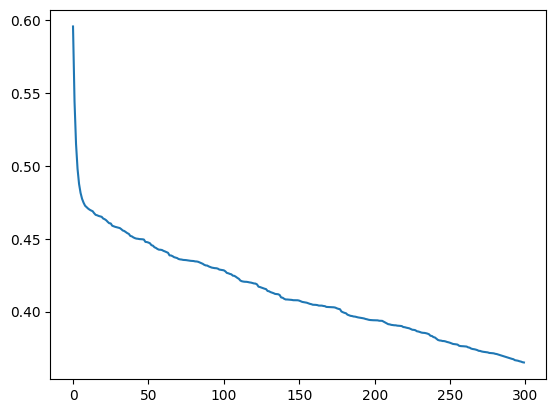

In [193]:
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
import numpy as np

In [194]:
np.unique(reg.predict(X_test), return_counts=True)

(array([0, 1]), array([124990,  30909]))

In [195]:
clean_test_data = dummies_df_anon (test_data) 
clean_test_data = transform_missing_ex_a(clean_test_data, average_price_diff)
clean_test_data = transf_adresses (clean_test_data) 
clean_test_data = dummies_df_wallet (clean_test_data) 
clean_test_data

,id,user_address,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,exchange_a_volatility,exchange_b_volatility,anonymous,anon_code_A,anon_code_F,anon_code_M,wallet_code_0x56ab,wallet_code_0x5779,wallet_code_0x5aee,wallet_code_0x930b,wallet_code_0xd47a
0,3988978,0x5779,51391.615731,1060.556537,0,0,35.954570,35.9667,NaN,NaN,F142,0,1,0,0,1,0,0,0
1,3988979,0x5779,91986.384059,218.535933,1,4,45.300626,45.0849,very high,0.000781,M1729,0,0,1,0,1,0,0,0
2,3989002,0x5779,41759.237681,1285.867013,0,0,37.481412,37.5039,very low,0.000562,F1542,0,1,0,0,1,0,0,0
3,3989008,0x5779,48074.340099,0.535869,0,0,40.753761,40.8303,low,0.000372,M1550,0,0,1,0,1,0,0,0
4,3989022,0x5aee,36021.119553,431.542705,0,0,70.976657,282.6852,low,0.000576,A638,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112825,5307776,0x5779,80592.884173,0.706920,0,0,39.991680,39.7971,very low,0.000707,F132,0,1,0,0,1,0,0,0
112826,5307781,0xd47a,107779.088520,423.156478,0,0,54.280719,54.2535,low,NaN,A16,1,0,0,0,0,0,0,1
112827,5307790,0x5779,118584.595142,110.042328,0,0,71.513852,71.4693,low,0.000264,A549,1,0,0,0,1,0,0,0
112828,5307800,0xd47a,88914.452535,695.334793,0,0,62.108812,62.1201,low,0.000284,A358,1,0,0,0,0,0,0,1


In [196]:
idx_test = get_ids (test_data)

In [197]:
clean_test_data = drop_columns_data (clean_test_data) 
clean_test_data

,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,anon_code_A,anon_code_F,anon_code_M,wallet_code_0x56ab,wallet_code_0x5779,wallet_code_0x5aee,wallet_code_0x930b,wallet_code_0xd47a
0,51391.615731,1060.556537,0,0,35.954570,35.9667,0,1,0,0,1,0,0,0
1,91986.384059,218.535933,1,4,45.300626,45.0849,0,0,1,0,1,0,0,0
2,41759.237681,1285.867013,0,0,37.481412,37.5039,0,1,0,0,1,0,0,0
3,48074.340099,0.535869,0,0,40.753761,40.8303,0,0,1,0,1,0,0,0
4,36021.119553,431.542705,0,0,70.976657,282.6852,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112825,80592.884173,0.706920,0,0,39.991680,39.7971,0,1,0,0,1,0,0,0
112826,107779.088520,423.156478,0,0,54.280719,54.2535,1,0,0,0,0,0,0,1
112827,118584.595142,110.042328,0,0,71.513852,71.4693,1,0,0,0,1,0,0,0
112828,88914.452535,695.334793,0,0,62.108812,62.1201,1,0,0,0,0,0,0,1


In [198]:
clean_test_data[list(clean_test_data.columns)] = scaler.transform(clean_test_data)

In [199]:
idx_test

0         3988978
1         3988979
2         3989002
3         3989008
4         3989022
           ...   
112825    5307776
112826    5307781
112827    5307790
112828    5307800
112829    5307806
Name: id, Length: 112830, dtype: int64

In [200]:
predictions_x_test_f = reg.predict_proba(clean_test_data)

In [201]:
results = pd.concat((idx_test, pd.DataFrame(predictions_x_test_f[:, 1])), axis=1, ignore_index=True)

In [202]:
results.columns = ["id","result"]

In [203]:
results.to_csv("submission_XBG_3.csv" ,index=False)